In [1]:
from huggingface_hub import notebook_login

notebook_login()

# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Loading the Dataset </div></b>

In [2]:
!pip install -q datasets

In [3]:
from datasets import load_dataset
from collections import defaultdict
from datasets import DatasetDict


langs = ["en", "de", "tr"]
fracs= [0.5, 0.5, 0.5]

panx_ds = defaultdict(DatasetDict)
 
for lang, frac in zip(langs, fracs):
    dataset = load_dataset("xtreme", name=f"PAN-X.{lang}")
    for split in dataset:
        panx_ds[lang][split] = (
            dataset[split].shuffle(seed=42).select(range(int(frac*dataset[split].num_rows))))

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.tr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Let's take a look at the number of training examples of all datasets:

In [4]:
import pandas as pd

pd.DataFrame({lang: [panx_ds[lang]["train"].num_rows] for lang in langs}, index=["number of training samples"])

,en,de,tr
number of training samples,10000,10000,10000


# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Understanding the Dataset </div></b>

In [5]:
row = panx_ds["en"]["train"][0]

for key, value in row.items():
    print(f"{key}: {value}")

tokens: ["''", 'January', '21', "''", '–', 'Nanny', 'and', 'the', 'Professor']
ner_tags: [0, 0, 0, 0, 0, 1, 2, 2, 2]
langs: ['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en']


In [6]:
for key, value in panx_ds["en"]["train"].features.items():
    print(f"{key}: {value}")

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Data Preprocessing </div></b>

In [7]:
labels = panx_ds["en"]["train"].features["ner_tags"].feature

def create_label_names(example):
    return {"ner_tags_str": [labels.int2str(idx) for idx in example["ner_tags"]]}

panx_en = panx_ds["en"].map(create_label_names)
en_example = panx_en["train"][0]
pd.DataFrame([en_example["tokens"], en_example["ner_tags_str"]], ["Tokens", "Labels"])

  0%|          | 0/10000 [00:00<?, ?ex/s]

  0%|          | 0/5000 [00:00<?, ?ex/s]

  0%|          | 0/5000 [00:00<?, ?ex/s]

,0,1,2,3,4,5,6,7,8
Tokens,'',January,21,'',–,Nanny,and,the,Professor
Labels,O,O,O,O,O,B-PER,I-PER,I-PER,I-PER


<Axes: >

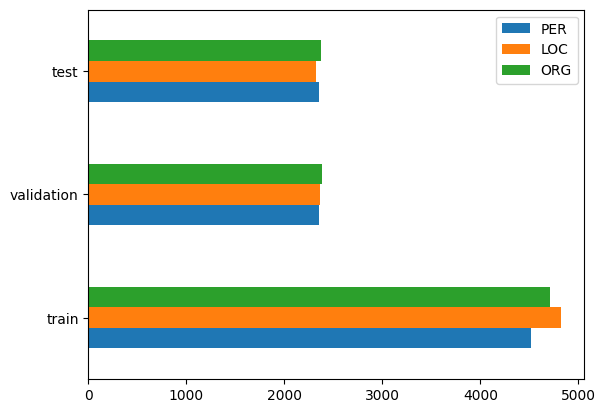

In [8]:
from collections import Counter

split2freqs = defaultdict(Counter)

for split, dataset in panx_en.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] +=1

pd.DataFrame.from_dict(split2freqs, orient = "index").plot(kind="barh")

# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Loading the XLM-Roberta Tokenizer & Model</div></b>

In [9]:
from transformers import AutoTokenizer

xlmr_tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

In [10]:
text = "MrBeast is an American YouTuber"

xlmr_tokens = xlmr_tokenizer(text).tokens()

pd.DataFrame([xlmr_tokens], index=["tokens"])

,0,1,2,3,4,5,6,7,8,9
tokens,<s>,▁Mr,Be,ast,▁is,▁an,▁American,▁YouTube,r,</s>


In [11]:
from transformers import XLMRobertaForTokenClassification
import torch

xlmr_model_name = "xlm-roberta-base"
index2label = {idx: label for idx, label in enumerate(labels.names)}
label2index = {label: idx for idx, label in enumerate(labels.names)}
num_labels = labels.num_classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

xlmr_model = XLMRobertaForTokenClassification.from_pretrained(
    xlmr_model_name,
    num_labels = num_labels,
    id2label=index2label,
    label2id=label2index
).to(device)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
def label_text(text, labels, model, tokenizer):
    tokens = tokenizer(text).tokens()
    input_ids = xlmr_tokenizer.encode(
        text, return_tensors = "pt").to(device)
    outputs = model(input_ids)[0]
    predictions = torch.argmax(outputs, dim=2)
    preds = [labels.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index = ["Tokens", "Tags"])

In [13]:
label_text(text, labels, xlmr_model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Mr,Be,ast,▁is,▁an,▁American,▁YouTube,r,</s>
Tags,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG


# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Tokenizer for NER Analysis </div></b>

In [14]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation = True, is_split_into_words = True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs        

In [15]:
def encode_panx_ds(corpus):
    return corpus.map(tokenize_and_align_labels,
                     batched=True,
                     remove_columns=["langs", "ner_tags", "tokens"])

panx_en_encoded = encode_panx_ds(panx_ds["en"])

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [16]:
tokenized_input = xlmr_tokenizer(panx_ds["en"]["train"][0]["tokens"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
word_ids = tokenized_input.word_ids()
tags = panx_en_encoded["train"][0]["labels"]

pd.DataFrame([tokens, word_ids, tags], index=["Tokens", "Word IDs", "Tags"])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,<s>,▁'',▁January,▁21,▁'',▁–,▁Nan,ny,▁and,▁the,▁Professor,</s>
Word IDs,None,0,1,2,3,4,5,5,6,7,8,None
Tags,-100,0,0,0,0,0,1,-100,2,2,2,-100


# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Model Metrics </div></b>

In [17]:
!pip install -q seqeval evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []
    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2label[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2label[preds[batch_idx][seq_idx]])
        
        labels_list.append(example_labels)  
        preds_list.append(example_preds) 
    
    return preds_list, labels_list

In [19]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Model Training </div></b>

In [20]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir = "roberta-base-NER",
    learning_rate=2e-5,
    per_device_train_batch_size = 12,
    per_device_eval_batch_size = 12,
    num_train_epochs = 2,
    weight_decay = 0.01,
    evaluation_strategy = "epoch", 
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to= "none",
    push_to_hub = True
)

In [21]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [22]:
from transformers import Trainer

trainer = Trainer(
    model = xlmr_model,
    args = training_args,
    data_collator = data_collator,
    compute_metrics = compute_metrics,
    train_dataset = panx_en_encoded["train"],
    eval_dataset = panx_en_encoded["validation"],
    tokenizer = xlmr_tokenizer,
)

trainer.train()
trainer.push_to_hub()

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1
1,No log,0.336062,0.747702
2,0.519600,0.306826,0.774903


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


'https://huggingface.co/Tirendaz/roberta-base-NER/tree/main/'

In [23]:
text = "MrBeast is an American YouTuber"

label_text(text, labels, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Mr,Be,ast,▁is,▁an,▁American,▁YouTube,r,</s>
Tags,B-LOC,B-PER,I-PER,O,O,O,B-ORG,I-PER,O,B-LOC


# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>Cross-Lingual Transfer</div></b>

In [24]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [32]:
def evaluate_lang_performance(lang, trainer):
    panx_dataset = encode_panx_ds(panx_ds[lang])
    return get_f1_score(trainer, panx_dataset["test"])

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

<Axes: >

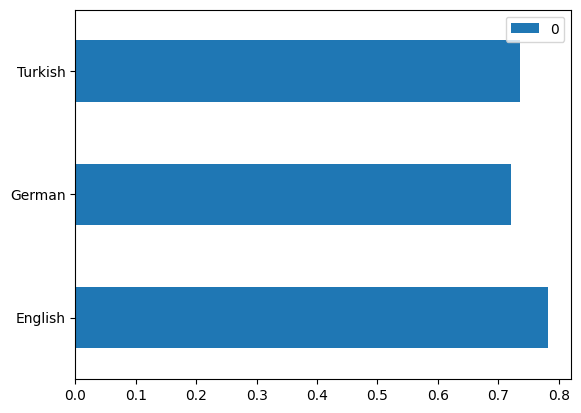

In [33]:
f1_scores_on_en = evaluate_lang_performance("en", trainer)
f1_scores_on_de = evaluate_lang_performance("de", trainer)
f1_scores_on_tr = evaluate_lang_performance("tr", trainer)

pd.DataFrame([f1_scores_on_en,f1_scores_on_de,f1_scores_on_tr],
             index=["English","German","Turkish"]).plot(kind="barh")

## Resource

- [NLP with Transformers](https://github.com/nlp-with-transformers/notebooks/blob/main/04_multilingual-ner.ipynb)

Thanks for reading. If you like this notebook, don't forget to upvote ☺️

Let's connect [YouTube](http://youtube.com/tirendazacademy) | [Medium](http://tirendazacademy.medium.com) | [X](http://x.com/tirendazacademy) | [Linkedin](https://www.linkedin.com/in/tirendaz-academy) 😎